**Wing loading and power loading selction using constraint diagrams, and initial sizing for a given weight**

In [31]:
import numpy as np
import matplotlib.pyplot as plt

- Input data

In [32]:
###################
#### DENSITIES ####
###################

# reference density
rho_0 = 1.225
# density (as a function of temperature ??)
#rho_c = 1.225
# worst case scenario : T_ext = 40 deg C, z_ext = 100m (geopotential)
#rho_min = 1.12

##################
#### GEOMETRY ####
##################

# wetted area to reference area ratio (-)
S_wet_S_ref = 4.5
# wing aspect ratio (-)
w_AR = 8

#################
##### SPEEDS ####
#################

# stall speed, flaps extended (m/s)
V_s = 10.0

# cruise speed (m/s)
V_cruise = 18.0

# max speed (m/s)
V_max = 30.0

# takeoff speed (m/s)
V_to = 1.1*V_s

# climb speed (m/s)
V_climb = 1.2*V_s


##############
#### WING ####
##############

# aerofoil max lift coefficient, with flaps, average along the full span (flapped and non flapped sections)
w_C_l_max_flaps = 2.3

# aerofoil lift gradient
w_C_l_alpha = 5.85 # E423, XFOIL prediction @ Re~300k-700k

# aerofoil zero lift angle
w_alpha_0_aerfoil = np.deg2rad(-3)

######################
#### EFFICIENCIES ####
######################
prop_efficiency = 0.80 # Raymer p.227

###########################
#### CLIMB PERFORMANCE ####
###########################

# cruise altitude (metres)
Z_c = 100

# time to reach cruise altitude (s)
t_Z_c = 60

# average vertical speed (m/s)
V_z_climb = Z_c/t_Z_c

# TAKEOFF
takeoff_dist = 50


- useful calculations

In [33]:
############################
##### DYNAMIC PRESSURES ####
############################

# cruise dynamic pressure
p_dyn_cruise  = 0.5*rho_0*V_cruise**2

# stall dynamic pressure
p_dyn_s = 0.5*rho_0*V_s**2

# max speed
p_dyn_max = 0.5*rho_0*V_max**2

# climb
p_dyn_climb = 0.5*rho_0*V_climb**2

###########################
#### CLEAN CONFIG DRAG ####
###########################

# max L/D
L_D_max = 9*np.sqrt(w_AR/S_wet_S_ref)  # Raymer - Concept. A/C Design : p.40 with K_LD = 9
print('L_D max =', L_D_max)

# oswald_eff (Raymer)
w_oswald_eff = 1.78*(1 - 0.045*w_AR**0.68) - 0.64
print('oswald e =', w_oswald_eff)

# induced drag factor ki = 1/piARe
w_k_i = 1/(np.pi*w_AR*w_oswald_eff)
print('ki =', w_k_i)

# parasitic drag
C_D_0 = np.pi*w_AR*w_oswald_eff/4/L_D_max**2
print('C_D_0 =', C_D_0)

###############
#### STALL ####
###############

# wing max lift coefficient, with flaps
w_C_L_max_flaps = 0.90 * w_C_l_max_flaps
print('C_L_max =', w_C_L_max_flaps)

###############
#### CLIMB ####
###############

# climb gradient
climb_gradient = V_z_climb/(1.2*V_s)
print('climb gradient =', climb_gradient)

# climb slope
print('gamma_climb = ', np.rad2deg(np.arctan(climb_gradient)), 'deg')

# climb aerodynamics
C_D_0_climb = C_D_0 + 0.02  # Raymer
oswald_eff_w_climb = w_oswald_eff * 0.95  # Raymer

# climb induced drag factor k_i = 1/piARe
k_i_climb = 1/(np.pi*w_AR*oswald_eff_w_climb)


L_D max = 12.0
oswald e = 0.8105923299393963
ki = 0.04908600082108922
C_D_0 = 0.03536876262213669
C_L_max = 2.07
climb gradient = 0.1388888888888889
gamma_climb =  7.907162702958458 deg


- Preparing the constraint diagrams : $\frac{T}{W} = f(\frac{W}{S})$ and $\frac{P}{W} = f(\frac{W}{S})$

In [34]:
# VARIABLE RANGES
W_S_range = np.linspace(50.0, 150.0, 20)
T_W_range = np.linspace(0.0, 1.0, 20)
P_W_range = np.linspace(0.0, 30.0, 20)

# STALL
W_S_stall = p_dyn_s * w_C_L_max_flaps

# CLIMB
T_W_climb = climb_gradient + p_dyn_climb*C_D_0_climb/W_S_range + k_i_climb*W_S_range/p_dyn_climb

# CRUISE
T_W_cruise = p_dyn_cruise*C_D_0/W_S_range + w_k_i*W_S_range/p_dyn_cruise

# MAX SPEED
T_W_vmax = p_dyn_max*C_D_0/W_S_range + w_k_i*W_S_range/p_dyn_max

# TAKE-OFF DISTANCE
def T_W_takeoff(W_S, C_D_0, k_i, V_s, V_takeoff, C_L_max, rho, S_g):
    """
    T/W ratio for a give W/S range
    S_g = ground rolling distance
    """

    # mu : rolling resistance coefficient
    # 0.03-0.05 : concrete runway
    # 0.05-0.07 : dry grass
    mu = 0.06

    # rotation duration (s)
    rotation_Dt = 1

    C_L_takeoff = C_L_max * (V_s/V_takeoff)**2
    
    # {roll acceleration distance} = {total distance on ground} - {rotation time}*V_takeoff
    S_roll = S_g - V_to * rotation_Dt

    K_a = rho/2/W_S * (mu*C_L_takeoff - C_D_0 - k_i*C_L_takeoff**2)
    T_W = mu + K_a * V_takeoff**2 / (np.exp(2*9.81*K_a*S_roll) - 1)

    return T_W
T_W_to = T_W_takeoff(W_S_range, C_D_0_climb, k_i_climb, V_s, V_to, w_C_L_max_flaps, rho_0, takeoff_dist)


- Plotting the constraint diagrams

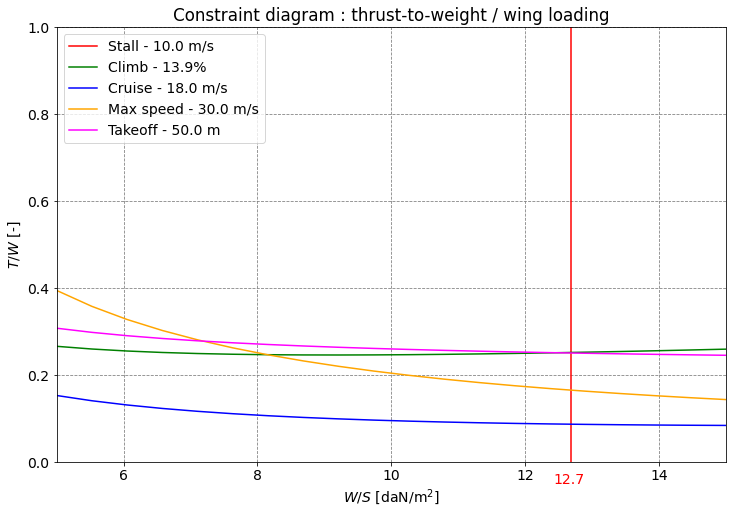

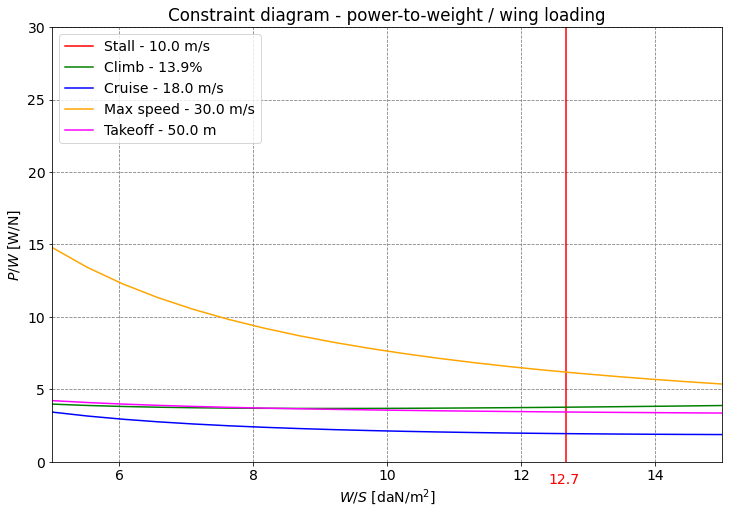

In [35]:
# DIAGRAMS
CONST_DIAG_THRUST_FLAG = 1
CONST_DIAG_POWER_FLAG = 1

plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.color'] = '0.5'
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.linestyle'] = '-'
plt.rcParams['lines.marker'] = ''
plt.rcParams['legend.fontsize'] = 14


# constraint diagram for THRUST-to-weight ratio
if CONST_DIAG_THRUST_FLAG:
    fig = plt.figure(figsize=(12, 8))
    plt.title('Constraint diagram : thrust-to-weight / wing loading')
    ax = plt.gca()

    # STALL
    plt.plot([W_S_stall/10, W_S_stall/10], [T_W_range[0], T_W_range[-1]],\
        'r-', label=f'Stall - {V_s} m/s')
    plt.text(W_S_stall/10-0.05*(W_S_range[-10]/10-W_S_range[0]/10),\
         -0.05*(T_W_range[-1]-T_W_range[0]), f'{W_S_stall/10:.1f}', color='r')

    # CLIMB
    plt.plot(W_S_range/10, T_W_climb, color='green', label=f'Climb - {100*climb_gradient:.1f}%')

    # CRUISE
    plt.plot(W_S_range/10, T_W_cruise, color='blue', label=f'Cruise - {V_cruise:.1f} m/s')

    # MAX SPEED
    plt.plot(W_S_range/10, T_W_vmax, color='orange', label=f'Max speed - {V_max:.1f} m/s')

    # TAKEOFF
    plt.plot(W_S_range/10, T_W_to, color='magenta', label=f'Takeoff - {takeoff_dist:.1f} m')


    # DIAGRAM PARAMETERS
    ax.legend()
    ax.set_xlabel('$W/S$ [daN/m${}^2$]')
    ax.set_ylabel('$T/W$ [-]')
    ax.set_xlim([W_S_range[0]/10, W_S_range[-1]/10])
    ax.set_ylim([T_W_range[0], T_W_range[-1]])
    plt.show()

# constraint diagram for POWER-to-weight ratio
if CONST_DIAG_POWER_FLAG:
    fig = plt.figure(figsize=(12, 8))
    ax = plt.gca()
    plt.title('Constraint diagram - power-to-weight / wing loading')

    # STALL
    M_S_stall = W_S_stall/9.81
    plt.plot([W_S_stall/10, W_S_stall/10], [P_W_range[0], P_W_range[-1]],\
        'r-', label=f'Stall - {V_s} m/s')
    plt.text(W_S_stall/10-0.05*(W_S_range[-10]/10-W_S_range[0]/10),\
         -0.05*(P_W_range[-1]-P_W_range[0]), f'{W_S_stall/10:.1f}', color='r')

    # CLIMB
    P_W_climb = T_W_climb * V_climb/prop_efficiency
    plt.plot(W_S_range/10, P_W_climb, color='green', label=f'Climb - {100*climb_gradient:.1f}%')

    # CRUISE
    P_W_cruise = T_W_cruise * V_cruise/prop_efficiency
    plt.plot(W_S_range/10, P_W_cruise, color='blue', label=f'Cruise - {V_cruise:.1f} m/s')

    # MAX SPEED
    P_W_vmax = T_W_vmax * V_max/prop_efficiency
    plt.plot(W_S_range/10, P_W_vmax, color='orange', label=f'Max speed - {V_max:.1f} m/s')

    # TAKEOFF
    P_W_to = T_W_to * V_to/prop_efficiency
    plt.plot(W_S_range/10, P_W_to, color='magenta', label=f'Takeoff - {takeoff_dist:.1f} m')


    # DIAGRAM PARAMETERS
    ax.legend()
    ax.set_xlabel('$W/S$ [daN/m${}^2$]')
    ax.set_ylabel('$P/W$ [W/N]')
    ax.set_xlim([W_S_range[0]/10, W_S_range[-1]/10])
    ax.set_ylim([P_W_range[0], P_W_range[-1]])
    plt.show()

- Choice of W/S and T/S...

In [36]:
# wing loading (kg/m^2)
M_S = 11.6

# thrust-to-weight ratio (-)
#T_W = 0.65

# power-to-weight ratio (W/N)
P_W = 16.0

- Initial sizing

In [37]:
# max takeoff weight range (kg)
MTOW = np.array([23, 24, 25])

#### WING PLANFORM ####
S_w = MTOW/M_S
print('S_w =', S_w,'m^2')

b_w = np.sqrt(w_AR * S_w)
print('b_w =', b_w, 'm')

C_w = S_w / b_w
print('C_w = ', C_w, 'm')

C_L_cruise = MTOW*9.81/(0.5*rho_0*V_cruise**2*S_w)
print('C_L_c', C_L_cruise)

# Polhamus' formula
C_L_alpha_w = ( 2*np.pi*w_AR ) / (2 + np.sqrt( (w_AR/(w_C_l_alpha/2/np.pi))**2 + 4))
print('C_L_alpha = ', C_L_alpha_w)

# wing setting angle
# Naylor's theorem : the wing accounts for the totality of the lift
# HTP has 0 lift in cruise condition
delta_w = C_L_cruise/C_L_alpha_w + w_alpha_0_aerfoil
print('delta_w = ', np.rad2deg(delta_w), 'deg')


#### POWERPLANT ####
P_engine = P_W * MTOW * 9.81
print('P_engine =', P_engine/1000, 'kW')

S_w = [1.98275862 2.06896552 2.15517241] m^2
b_w = [3.9827213  4.06838102 4.15227399] m
C_w =  [0.49784016 0.50854763 0.51903425] m
C_L_c [0.57342404 0.57342404 0.57342404]
C_L_alpha =  4.644713695377201
delta_w =  [4.07358501 4.07358501 4.07358501] deg
P_engine = [3.61008 3.76704 3.924  ] kW
